# Graded Lab

In [1]:
#Install all the requirements
import subprocess
#yes= 1
#no = 0
def installRequirements(yes):
    try:
        if yes > 0:
            subprocess.run(['pip', 'install', '-r', './requirements.txt'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            print("All libraries installed")
    except:
        print("Error while installing all required libraries")
        
installRequirements(0)


In [1]:
import tensorflow as tf
from tensorflow import keras
import cv2,os, random,time,glob,pickle
import imageio.v3 as Imageio
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms
from torchvision import datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm
import plotly.express as px
import seaborn as sns
from IPython import display

2023-03-16 09:17:50.627132: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 09:17:51.011365: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-16 09:17:51.011407: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-16 09:17:52.300909: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
#The dataset 
num_apes = len(os.listdir('./img/'))
print("The dataset has {} elements".format(num_apes))

The dataset has 9999 elements


In [4]:
def paintImgs(numF, numC, sizeW, sizeH):
    numPlots = numF*numC
    plt.rcParams['figure.figsize'] = (sizeW,sizeH)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    for idx,img in enumerate(apes[:numPlots]):
        sample_img = cv2.imread(img)
        plt.subplot(numF, numC, idx+1)
        plt.axis('off')
        plt.imshow(cv2.cvtColor(sample_img,cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    plt.show()

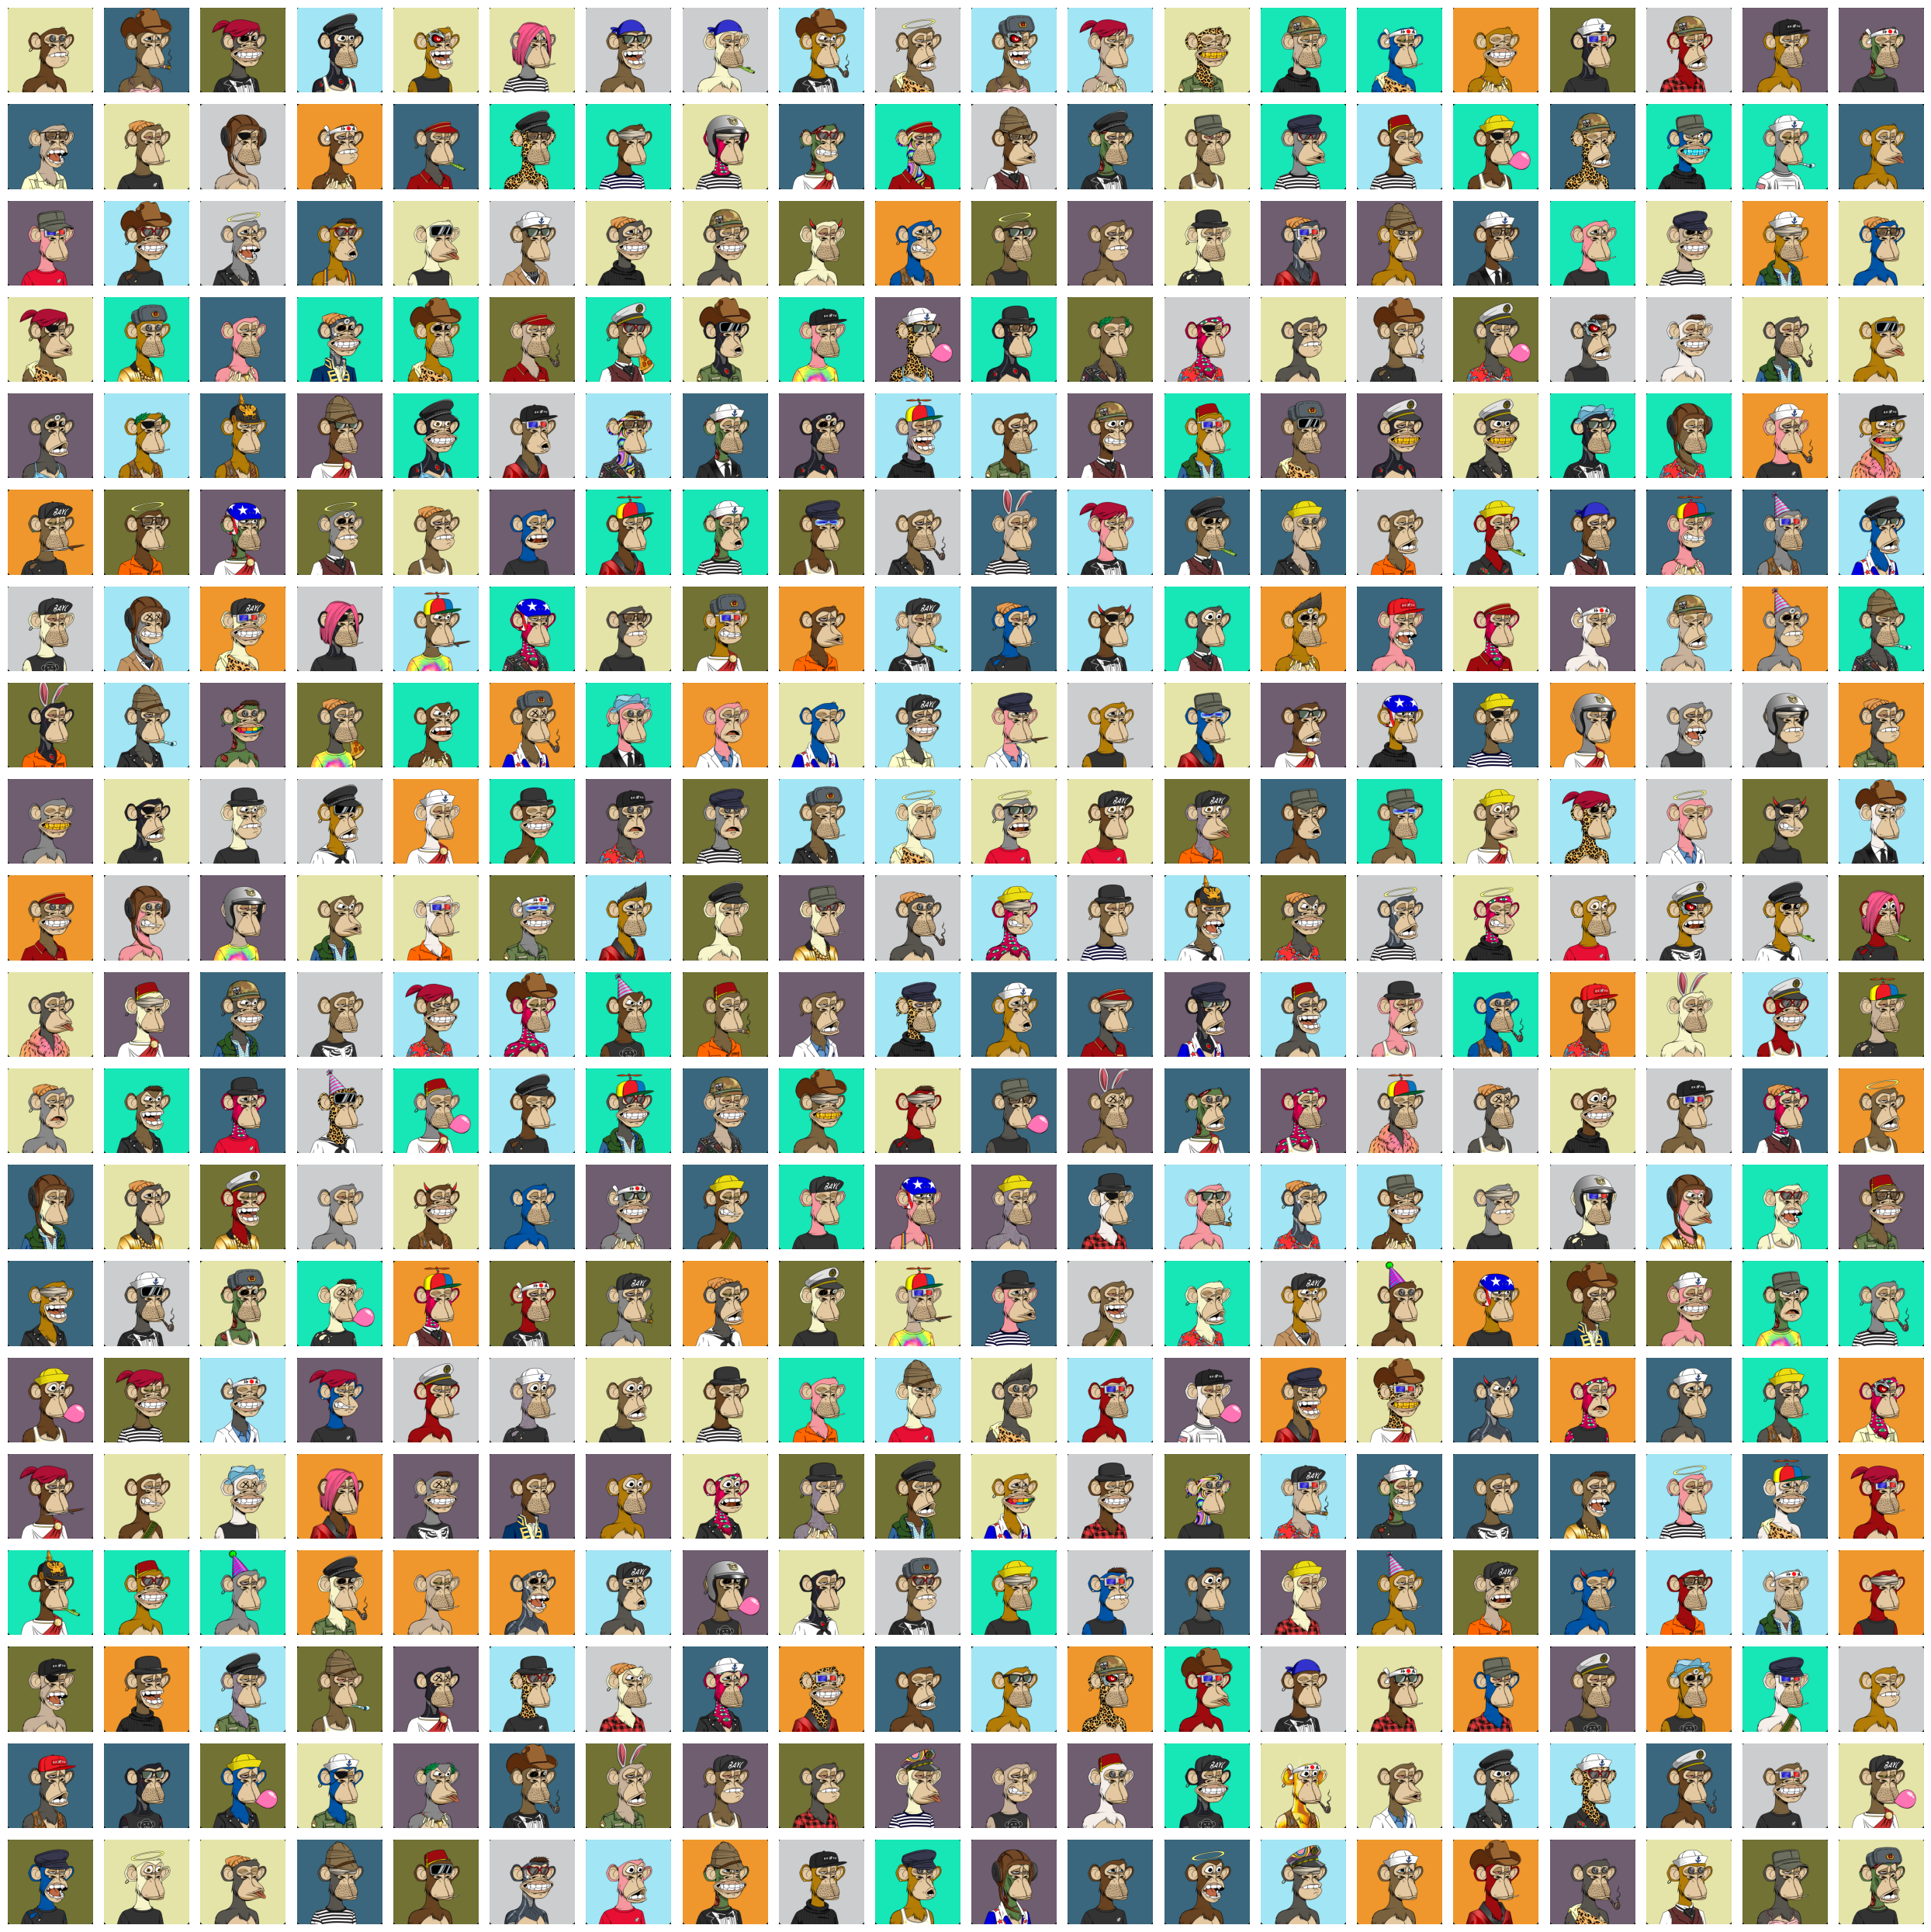

In [5]:
#First Look
apes = glob.glob("./img/*.jpg")  
paintImgs(20,20,25,25)

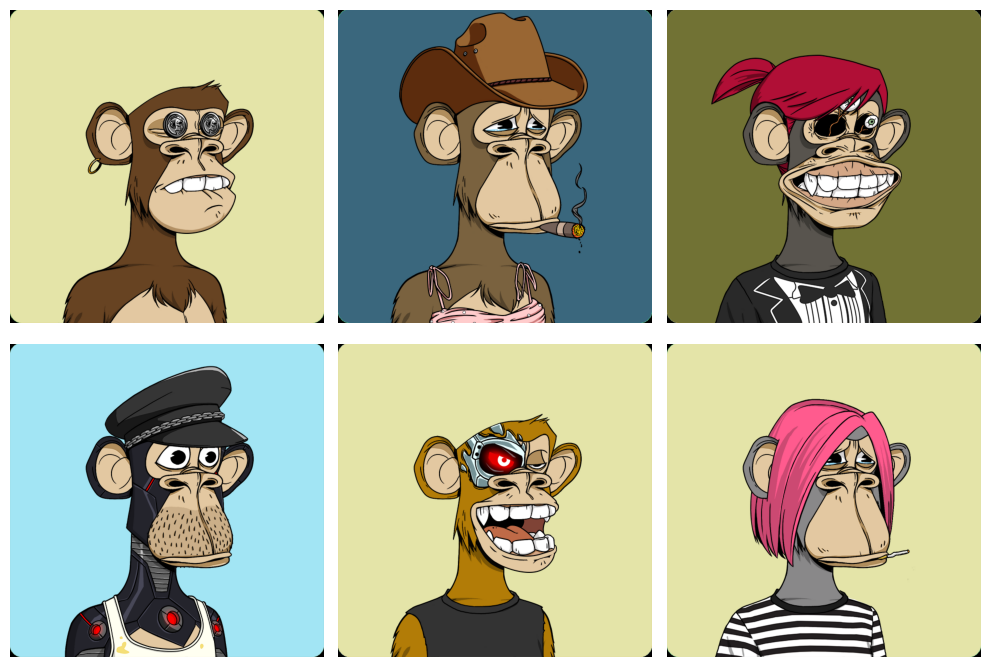

In [6]:
#A little bit closer
paintImgs(2,3,10,7)#First Look

In [7]:
#Get Images Size

img = "./img/QmdVB9AZW5KqdrUNzwb5HeFXqrUMWwPXCEnKjrXZ6Jq4rU.jpg"
height, width = Image.open(img).size
print(f'The Images size is {width}x{height}')


The Images size is 631x631


In [8]:

"""
Resize all the img
original 631x631
result 64x64
"""
SIZE = 64

for image in glob.glob("./img/*.jpg"):
    #try:
        img = cv2.imread(image, cv2.IMREAD_COLOR)
        #print(image)
        imageSize = (SIZE,SIZE)
        img = cv2.resize(img, imageSize, interpolation=cv2.INTER_AREA)
        cv2.imwrite("./littleImg/monkeys" + image.split("/")[2], img)
    #except: #Corrupted img
        #os.remove("./img/" + image)
        #pass

In [9]:
img = "./littleImg/monkeys/QmdVB9AZW5KqdrUNzwb5HeFXqrUMWwPXCEnKjrXZ6Jq4rU.jpg"
height, width = Image.open(img).size
print(f'The Images size is {width}x{height}')

The Images size is 64x64


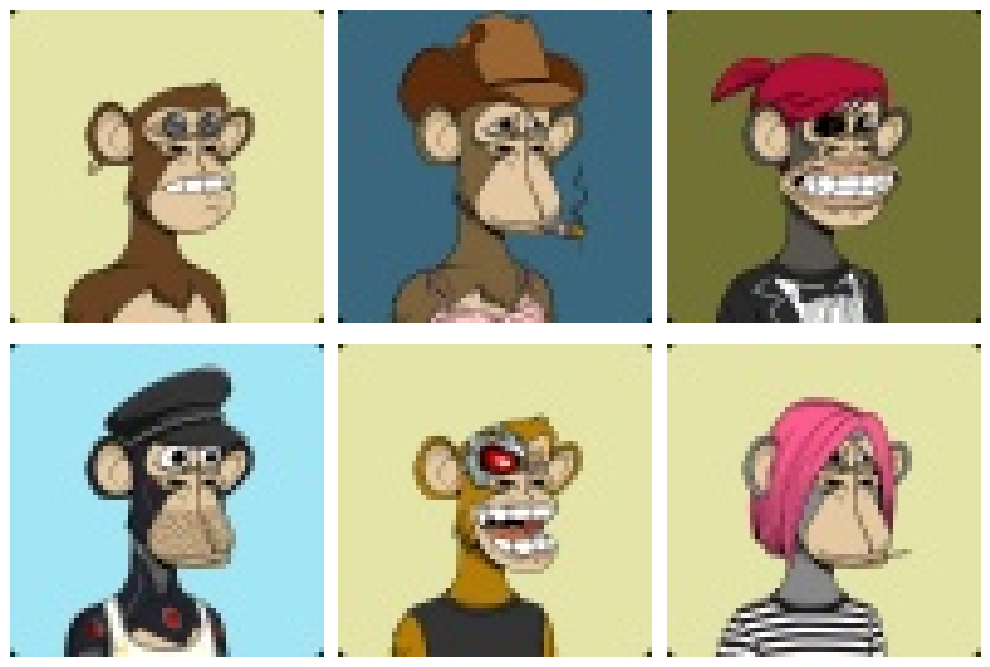

In [10]:
apes = glob.glob("./littleImg/monkeys/*.jpg")  
paintImgs(2,3,10,7)#First Look

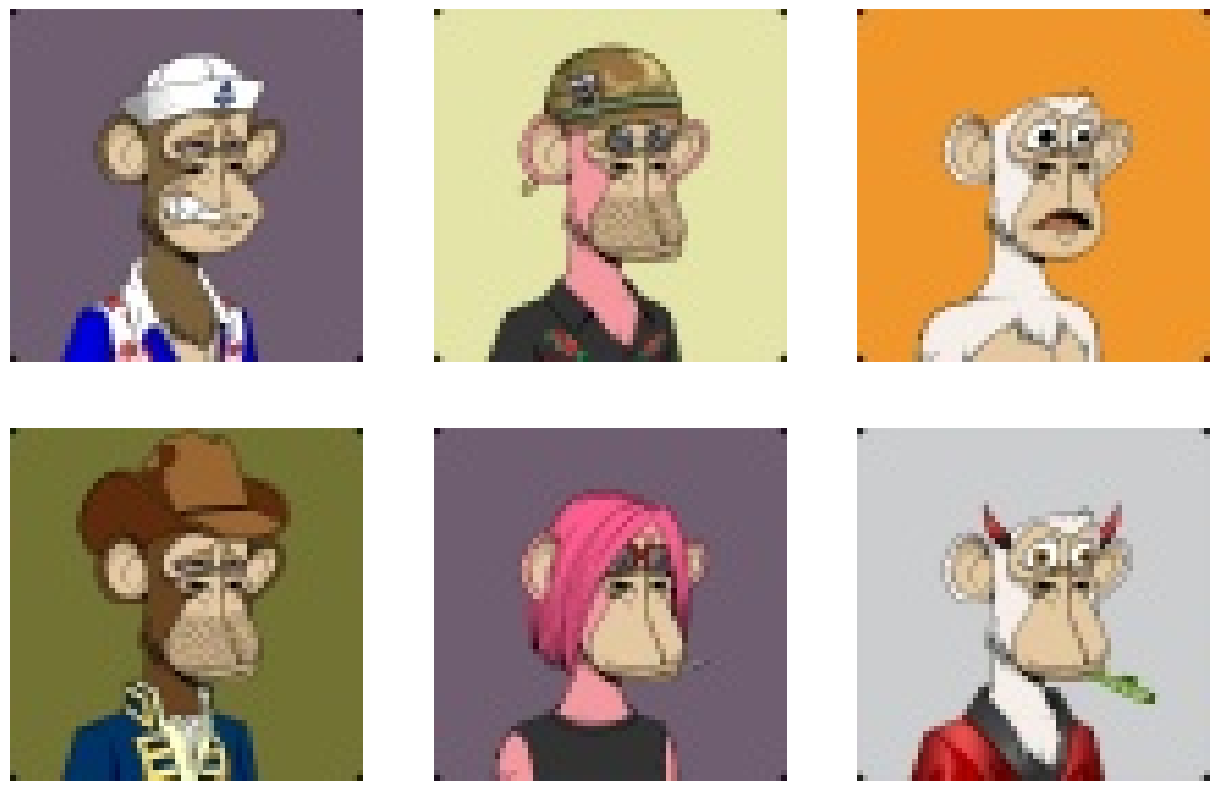

In [5]:
IMAGE_DIR = "./littleImg/"
NUM_WORKERS = 4
BATCH_SIZE = 64
SIZE = 64

import torch
"""
Custom size
"""
import torchvision
class IdentityTransform(torchvision.transforms.Resize):
    def __call__(self, img):
        return img

"""

Used to convert an image represented as a tensor to a NumPy array

"""
def tensor(img, dnorm):
    if not isinstance(img, torch.Tensor):
        raise TypeError("Input must be a PyTorch tensor.")
    img = img.cpu().detach().numpy()
    if dnorm:
        img = (img + 1) / 2
    img = np.transpose(img, (0, 2, 3, 1)) if img.ndim == 4 else np.transpose(img, (1, 2, 0))
    
    return img
  
    
"""

load images from a directory,normalize the pixel values, and create a PyTorch object 
that can be used to iterate over batches of images for training model

"""
def get_dataloader(batch_size = BATCH_SIZE,       
                   image_size = SIZE,           
                   data_dir=IMAGE_DIR,   
                   num_workers=NUM_WORKERS):      
    
    stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
        
    """The resize value is 1 because the imgs are already resize
    Custom size function created to avoid resize
    """
    transform = transforms.Compose([transforms.Resize((SIZE, SIZE)),transforms.ToTensor(),transforms.Normalize(*stats)]) 
    data_loader = torch.utils.data.DataLoader(datasets.ImageFolder(root=data_dir,
                                   transform=transform),
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=num_workers,
                                              pin_memory=True)
    return data_loader



"""Plot the result"""
test = get_dataloader()
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0.2, hspace=0.1)

for i, (img, _) in enumerate(test):
    if i >= 6:
        break
    ax = axes[i//3, i%3]
    ax.imshow(tensor(img[-1], True), aspect='equal')
    ax.axis('off')
    
plt.show()

#### Discriminator

Implements the discriminator architecture in a GAN. The discriminator has as input an image x and produces an output representing the probability that the image is real (1) or generated (0).

The discriminator architecture is defined by a series of convolutional layers, each of which gradually decreases the size of the image and increases the number of channels. The make_disc_block function is used to create each convolutional layer of the discriminator. The last convolutional layer has a single output channel, which is reduced to a single value (via the squeeze function) that is used to calculate the classification loss.

The forward function of the discriminator simply takes the input x and passes it through the sequence of convolutional layers defined in self.disc_cnn. The output is then flattened and reduced to a single value through view and squeeze, respectively, before being returned.

In [6]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=3, conv_dim=64, image_size=64):
        super(Discriminator, self).__init__()
        self.image_size = image_size
        self.conv_dim = conv_dim
        self.disc_cnn = nn.Sequential(
            self.make_disc_block(im_chan, conv_dim),
            self.make_disc_block(conv_dim, conv_dim*2),
            self.make_disc_block(conv_dim*2, conv_dim*4),
            self.make_disc_block(conv_dim*4, conv_dim*8),
            self.make_disc_block(conv_dim*8, 1, padding=0, final_layer=True))
        
    def make_disc_block(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, final_layer=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)]
        if not final_layer:
            layers += [nn.BatchNorm2d(out_channels), nn.LeakyReLU(0.2, inplace=True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.disc_cnn(x).view(x.size(0), -1).squeeze(1)
    
    
Discriminator(im_chan=3,conv_dim=64,image_size=64)


Discriminator(
  (disc_cnn): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affi

#### Generator

This code defines the architecture of a Generator model in a generative adversarial network (GAN) for image generation. The goal of the GAN is to generate realistic images that resemble the original training images.

The Generator model takes as input a random noise tensor with a dimension of z_dim (in this case, 100), and produces an image of size (im_chan x 64 x 64), where im_chan is the number of channels in the image (in this case, 3 for RGB colour images).

The Generator model is built using a transposed convolutional architecture (or deconvolution), which is the inverse operation of a convolution. Instead of reducing the image size with pooling, transposed convolution increases the image size with stride=2. This allows the Generator model to gradually increase the image size while maintaining high resolution and image detail. BatchNorm and ReLU layers are also used to improve the performance and stability of the model.

The forward() method takes the random noise tensor and reshapes it to a tensor of size (n_samples x z_dim x 1 x 1) before passing it through the transposed convolution architecture to generate the output image.

The get_noise() function is a static method used to generate a random noise tensor with the correct dimension for the Generator model. This is useful for generating random samples of images from the trained model.

In [7]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, z_dim=100, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()

        self.z_dim = z_dim
        self.im_chan = im_chan
        self.hidden_dim = hidden_dim

        self.generator_cnn = nn.Sequential(
            
            # input: N x z_dim x 1 x 1
            nn.ConvTranspose2d(z_dim, hidden_dim * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(hidden_dim * 8),
            nn.ReLU(),

            # state size: (hidden_dim*8) x 4 x 4
            nn.ConvTranspose2d(hidden_dim * 8, hidden_dim * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.ReLU(),

            # state size: (hidden_dim*4) x 8 x 8
            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(),

            # state size: (hidden_dim*2) x 16 x 16
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),

            # state size: hidden_dim x 32 x 32
            nn.ConvTranspose2d(hidden_dim, im_chan, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh() # output: im_chan x 64 x 64
        )

    def forward(self, noise):
        x = noise.view(-1, self.z_dim, 1, 1)
        return self.generator_cnn(x)

    
    @staticmethod
    def get_noise(n_samples, z_dim, device='cpu'):
        return torch.randn(n_samples, z_dim, device=device)

#test Generator
noise = Generator.get_noise(n_samples=5, z_dim=100)
Generator(z_dim=100, im_chan=3,hidden_dim=64)


Generator(
  (generator_cnn): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

#### weights

Function weights_init_normal is a weight initialization function that initializes the weights of a Convolutional Neural Network (CNN) layer using a normal distribution with mean 0 and standard deviation 0.02. It also initializes the biases of Conv2D and ConvTranspose2D layers to zero, and the biases of BatchNorm2D layers to zero.

In [8]:
def weights_init_normal(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.zeros_(m.bias)

#### Loss

real_loss calculates the loss for the discriminator when it tries to correctly classify real images. It uses the Binary Cross Entropy with Logits Loss (BCEWithLogitsLoss) function, sets the label to be 0.9 instead of 1 to implement label smoothing, and returns the calculated loss.

In [9]:
def real_loss(D_out, device='cpu'):
    criterion = nn.BCEWithLogitsLoss()
    batch_size = D_out.size(0)
    labels = torch.full((batch_size,), 0.9, device=device)
    loss = criterion(D_out.view(-1), labels)
    return loss

fake_loss calculates the loss for the discriminator when it tries to correctly classify fake images generated by the generator. It uses the BCEWithLogitsLoss function, sets the label to be 0 for fake images, and returns the calculated loss

In [10]:
def fake_loss(D_out, device='cpu'):

    criterion = nn.BCEWithLogitsLoss()
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size, device=device)
    loss = criterion(D_out.view(-1), labels)
    return loss

#### Hyperparameters

In [11]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

z_dim = 100 
beta_1 = 0.5      
beta_2 = 0.999 
lr = 0.0002       
n_epochs = 200
batch_size = BATCH_SIZE
image_size = SIZE
start_from = 70

# Train the Model

The training process consists of making the Discriminator learn to distinguish between the generated images and the real ones, while the Generator learns to fool the Discriminator by producing images that are difficult to distinguish from the real ones.

In this code, we use a convolutional Discriminator model that takes 64x64 pixel images and a Generator model that takes a random vector of size 100 and produces a 64x64 pixel image. Training is performed for a set number of epochs and at each epoch the weights of both models are updated using a down gradient optimiser.

During training, the Discriminator and Generator losses are printed to evaluate the progress of the model. In addition, model weights are saved in a checkpoint file after each epoch.

In [12]:
from tqdm import tqdm

"""
-im_chan: It is the number of channels of the input image (RGB).
-conv_dim: It is the number of channels in the last convolutional layer before the final linear layer of the 
discriminator. The more channels there are, the more complex features the discriminator can learn to detect
-image_size: It is the expected size of the square input image
-z_dim noise

-discriminator.parameters(): It's a list of all the trainable parameters of the discriminator.
-lr: It's the learning rate, which determines how fast the parameters are updated during training.
-betas: They are the beta1 and beta2 momentum parameters, which are used to calculate the first and second-order 
moment estimates of the gradients. These parameters are usually set by default to (0.9, 0.999) and are used to 
speed up training and smooth out fluctuations in the parameter updates.

"""
BATCH_SIZE
discriminator = Discriminator(im_chan=3, conv_dim=64, image_size=image_size).to(device)
d_optimizer = optim.Adam(discriminator.parameters(),lr=lr, betas=(beta_1, beta_2))
generator = Generator(z_dim, im_chan=3,hidden_dim=64).to(device)

g_optimizer = optim.Adam(generator.parameters(),lr=lr, betas=(beta_1, beta_2))

dataloader = get_dataloader()


def train(D, G, n_epochs, dataloader, d_optimizer, g_optimizer, z_dim, start, print_every=1, device='cpu'):

    sample_size = 8
    fixed_z = G.get_noise(n_samples=sample_size, z_dim=z_dim, device=device)
    G.train()

    for epoch in range(start+1, n_epochs + 1):

        d_losses, g_losses = [], []

        for real_images, _ in tqdm(dataloader, desc=f'Epoch {epoch}/{n_epochs}'):

            batch_size = real_images.size(0)
            real_images = real_images.to(device)

            #===================== Discriminator ====================

            d_optimizer.zero_grad()
            d_real_op = D(real_images)
            d_real_loss = real_loss(d_real_op, device=device)
            noise = G.get_noise(n_samples=BATCH_SIZE, z_dim=z_dim, device=device)
            fake_images = G(noise)
            d_fake_op = D(fake_images)
            d_fake_loss = fake_loss(d_fake_op, device=device)
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            #===================== Generator ====================
        
            g_optimizer.zero_grad()
            noise = G.get_noise(n_samples=batch_size, z_dim=z_dim, device=device)
            g_out = G(noise)
            G.eval()
            d_out = D(g_out)
            G.train()

            g_loss = real_loss(d_out, device=device)
            g_loss.backward()
            g_optimizer.step()

            
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())


        print(f"d_loss {sum(d_losses) / len(d_losses)} || g_loss {sum(g_losses) / len(g_losses)}")

        if epoch % print_every == 0:
            with torch.no_grad():
                G.eval()
                sample_image = G(fixed_z)
                print_tensor_images(sample_image)
                G.train()
                
        checkpoint_path = f'./ml/checkpoint_epoch_{epoch}.pt'
        torch.save({
            'epoch': epoch,
            'generator_state_dict': G.state_dict(),
            'discriminator_state_dict': D.state_dict(),
            'generator_optimizer_state_dict': g_optimizer.state_dict(),
            'discriminator_optimizer_state_dict': d_optimizer.state_dict(),
            'generator_loss': sum(g_losses) / len(g_losses),
            'discriminator_loss': sum(d_losses) / len(d_losses)
        }, checkpoint_path)
        

def print_tensor_images(images_tensor):
        
    plt.rcParams['figure.figsize'] = (15, 15)
    plt.subplots_adjust(wspace=0, hspace=0)
    
    images_tensor = images_tensor.to('cpu')
    npimgs = images_tensor.detach().numpy()
    
    no_plots = len(images_tensor)

    for idx,image in enumerate(npimgs):
        plt.subplot(1, 8, idx+1)
        plt.axis('off')
        image = image * 0.5 + 0.5
        plt.imshow(np.transpose(image, (1, 2, 0)))
        
    plt.show()


Epoch 70/200: 100%|███████████████████████████| 157/157 [05:53<00:00,  2.25s/it]


d_loss 0.3500611711839202 || g_loss 5.539890389533559


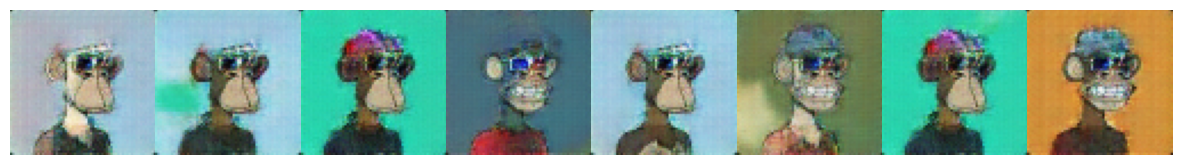

Epoch 71/200:   1%|▎                            | 2/157 [00:06<08:16,  3.20s/it]

Train interrupted


In [13]:
#start training

"""
To resume the training for the past trainings start_from > 0
"""
if start_from > 0:
    checkpoint_path = './ml/checkpoint_epoch_{}.pt'.format(start_from)
    checkpoint = torch.load(checkpoint_path)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    g_optimizer.load_state_dict(checkpoint['generator_optimizer_state_dict'])
    d_optimizer.load_state_dict(checkpoint['discriminator_optimizer_state_dict'])

try:
    train(discriminator,
          generator,
          n_epochs,
          dataloader,
          d_optimizer,
          g_optimizer,
          z_dim,
          start_from,
          print_every=1,
          device=device)
except KeyboardInterrupt:
    print("Train interrupted") 

# Final Result

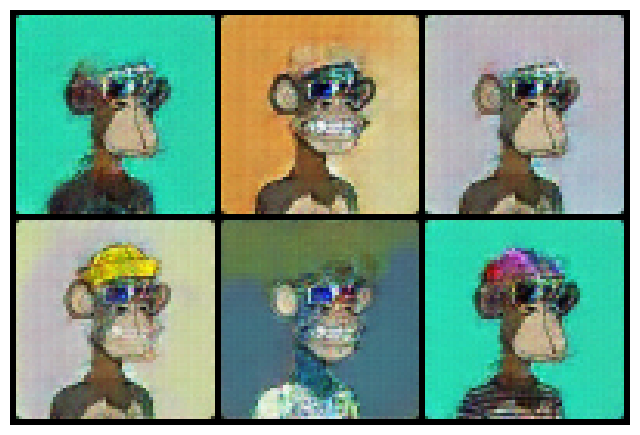

In [15]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils


"""
Generate new images from a specific epoch
"""
n_epoch = 70

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the checkpoint
checkpoint_path = './ml/checkpoint_epoch_{}.pt'.format(n_epoch)
checkpoint = torch.load(checkpoint_path)

# Load the generator and discriminator models from the checkpoint
generator.load_state_dict(checkpoint['generator_state_dict'])
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])

# Set the optimizers with the saved state dicts
g_optimizer.load_state_dict(checkpoint['generator_optimizer_state_dict'])
d_optimizer.load_state_dict(checkpoint['discriminator_optimizer_state_dict'])

# Get the epoch number from the checkpoint
epoch = checkpoint['epoch']

# Generate images from the generator
sample_size = 6
fixed_z = generator.get_noise(n_samples=sample_size, z_dim=z_dim, device=device)

with torch.no_grad():
    generator.eval()
    fake_images = generator(fixed_z)
    generator.train()

# Plot the generated images
grid = vutils.make_grid(fake_images, nrow=3, normalize=True)

plt.figure(figsize=(8, 6))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()
